# Quantum State Tomography

Let's try to do the tomography of a given one-qubit quantum state just to understand the principle behind this procedure:

\begin{equation}
    \rho = \begin{pmatrix}
                \rho_{11} & \rho_{12} \\
                \rho_{21} & \rho_{22}
           \end{pmatrix} =  \frac{1}{2} \sum_{i=0}^3 S_i \sigma_i
\end{equation}

Where  $\rho_{11} + \rho_{22} = 1$, $\rho_{12} = \rho_{21}^*$, and $\sigma_i$ are the pauli matrices. 

$$
\sigma_0 = I \ \ \ \sigma_1 = \sigma_x = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix} \ \ \ \sigma_2 = \sigma_y = \begin{pmatrix} 0 & i \\ -i & 0 \end{pmatrix} \ \ \ \sigma_3 = \sigma_z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$

Our goal is to find $S_i$ an then characterize the state.

A problem is that the IBM quantum computers only measures on the Z axis, therefore we only can know $S_3$ that is associated as the expected value of the measurement along the Z axis. 
We need to do a trick to be able to measure $\big<X\big>$ and $\big<Y\big>$.

Let's first check what are the eigenvectors of those operators.

- X has as eigenvectors $\left| + \right> = \frac{1}{\sqrt{2}} \bigg( \left| 0 \right> + \left| 1 \right> \bigg)$ and $\left| - \right> = \frac{1}{\sqrt{2}} \bigg( \left| 0 \right> - \left| 1 \right> \bigg)$.

- Y has as eigenvectors $\left| i^+ \right> = \frac{1}{\sqrt{2}} \bigg( \left| 0 \right> + i\left| 1 \right> \bigg)$ and $\left| i^- \right> = \frac{1}{\sqrt{2}} \bigg( \left| 0 \right> - i\left| 1 \right> \bigg)$.


Thus to measure on those bases we need only to add a way to generate those eigenvectors on the circuit:

- To generate X, we only need to apply H. 
- To generate Y, we need to apply HS.

In [1]:
import qiskit as qsk
import numpy as np
import matplotlib.pyplot as plt

In order to test this, conseder we have the state $\left| \psi \right> = \bigg( \frac{1}{\sqrt{3}}\left| 0 \right> + \frac{1}{\sqrt{2}}\left| 1 \right> \bigg)$ and we want to do the tomography of this state.

In [2]:
def measure_X(circuit,n):    
    circuit.barrier(n)
    circuit.h(n)
    circuit.measure(n,n)
    return circuit

def measure_Y(circuit,n):    
    circuit.barrier(n)
    circuit.sdg(n)
    circuit.h(n)    
    circuit.measure(n,n)    
    return circuit

def tomography(circuit):
    """ Tomography of a one qubit Circuit.
    """
    qc_list = []
    base = ['X', 'Y', 'Z']
    for basis in base:
        Q = qsk.QuantumCircuit(1,1)
        Q.append(circuit, [0])
        if basis == 'X':
            measure_X(Q, 0)
            qc_list.append(Q)
        if basis == 'Y':
            measure_Y(Q,  0)
            qc_list.append(Q)
        if basis == 'Z':
            Q.measure(0,0)
            qc_list.append(Q)
    return qc_list, base

In [3]:
qc = qsk.QuantumCircuit(1)
qc.h(0)
qcs, bases = tomography(qc)

Running tomography

In [4]:
backend_sim = qsk.Aer.get_backend('qasm_simulator')
job = qsk.execute(qcs, backend_sim, shots=5000)
result = job.result()

for index, circuit in enumerate(qcs):
    print(result.get_counts(circuit))
    print(f'Base measured {bases[index]}\n')

{'0': 5000}
Base measured X

{'1': 2474, '0': 2526}
Base measured Y

{'1': 2522, '0': 2478}
Base measured Z



In [5]:
def get_density_matrix(measurements,circuits):
    """Get density matrix from tomography measurements.

    """
    density_matrix = np.eye(2, dtype=np.complex128)
    sigma_x = np.array([[0,1],[1,0]])
    sigma_y = np.array([[0,-1j],[1j,0]])
    sigma_z = np.array([[1,0],[0,-1]])
    basis = [sigma_x, sigma_y, sigma_z]

    for index in range(len(circuits)):
        R = measurements.get_counts(index)
        
        if '0' in R.keys() and '1' in R.keys():
            zero = R['0']
            one = R['1']
        
        elif '1' in R.keys():
            zero = 0
            one = R['1']
        
        elif '0' in R.keys():
            zero = R['0']
            one = 0

        total = sum(list(R.values()))
        expected = (zero - one)/total        
        density_matrix += expected * basis[index]

    return 0.5*density_matrix

density = get_density_matrix(result,qcs)
print(density)

[[0.4956+0.j     0.5   -0.0052j]
 [0.5   +0.0052j 0.5044+0.j    ]]


Thus we have: X = 1, Y = 0 and Z = 0. Writing the density matrix:

\begin{equation}
    \rho = \frac{1}{2} \begin{pmatrix} 
            1 & 1 \\
            1 & 1
           \end{pmatrix}
\end{equation}

In [6]:
def plot_density_matrix(DM):
    """Helper function to plot density matrices.

    Parameters
    ----------------------------------------------
    DM(np.array): Density Matrix.
    
    """
    from matplotlib.ticker import MaxNLocator
    
    fig = plt.figure(figsize=(16,10))
    gs = fig.add_gridspec(1, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    im = ax1.imshow(np.real(DM), cmap='Greys')
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_title('Real Part',size=16)
    plt.colorbar(im, ax=ax1)

    im = ax2.imshow(np.imag(DM), cmap='Greys')
    plt.colorbar(im, ax=ax2)
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_title('Imaginary Part',size=16)
    plt.show()

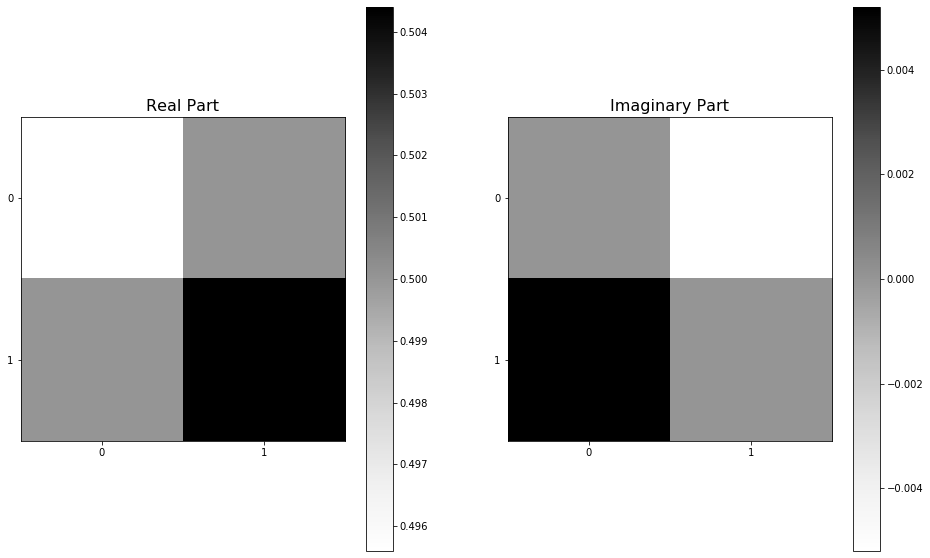

In [7]:
plot_density_matrix(density)

Qiskit has a module inside ignis to do [tomography](https://qiskit-staging.mybluemix.net/documentation/ignis/tomography.html) that does exactly what we've done before, but is generalized for multiple qubits as input.

In [8]:
from qiskit.ignis.verification.tomography import state_tomography_circuits

tomography_circuits = state_tomography_circuits(qc, [0], meas_labels='Pauli', meas_basis='Pauli')

As a check, let's see how they measure the Y basis, and we can verify that it is the same way as we did before.

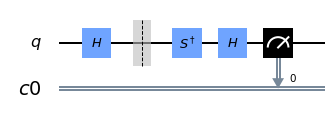

In [9]:
tomography_circuits[1].draw('mpl')

In [10]:
backend_sim = qsk.Aer.get_backend('qasm_simulator')
job = qsk.execute(tomography_circuits, backend_sim, shots=5000)
result = job.result()

They also has a function to transform the results to a density matrix which treats the state tomography as an optimization problem. The `fit` method has several methods for fitting the tomography results, such as `cvx` which is convex optimization and `lstsq` which makes uses the least square optimization.

In [11]:
from qiskit.ignis.verification.tomography import StateTomographyFitter

state_fitter = StateTomographyFitter(result, tomography_circuits, meas_basis='Pauli')

In [12]:
density_matrix = state_fitter.fit(method='lstsq')
print(density_matrix)

[[0.49720042+0.j         0.49992494+0.00819877j]
 [0.49992494-0.00819877j 0.50279958+0.j        ]]


Which is approximately what we expect, as shown before.

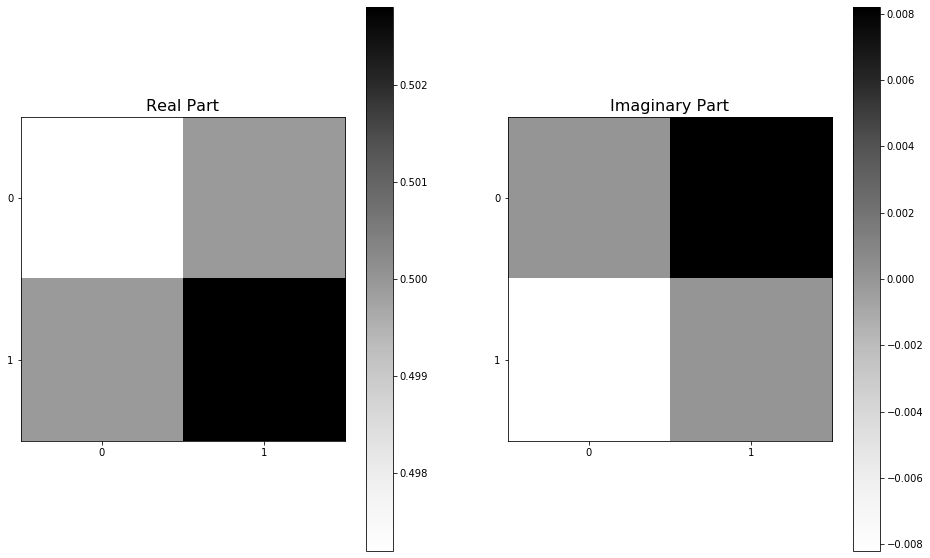

In [13]:
plot_density_matrix(density_matrix)

## Let's do the State tomography of 3 qubits

For this example, lets use the GHZ state:

\begin{equation}
    \left| \psi \right> = \frac{1}{\sqrt{2}} \bigg( \left| 000 \right> + \left| 111 \right> \bigg)
\end{equation}

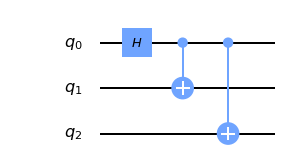

In [20]:
qc = qsk.QuantumCircuit(3)
qc.h(0)
qc.cx(0,1)
qc.cx(0,2)
qc.draw('mpl')

In [21]:
from qiskit.ignis.verification.tomography import state_tomography_circuits

tomography_circuits = state_tomography_circuits(qc, [0,1,2], 
                                                meas_labels='Pauli', 
                                                meas_basis='Pauli')
backend_sim = qsk.Aer.get_backend('qasm_simulator')
job = qsk.execute(tomography_circuits, backend_sim, shots=5000)
result = job.result()

In [22]:
from qiskit.ignis.verification.tomography import StateTomographyFitter

state_fitter = StateTomographyFitter(result, tomography_circuits, meas_basis='Pauli')

In [24]:
density_matrix = state_fitter.fit(method='lstsq')

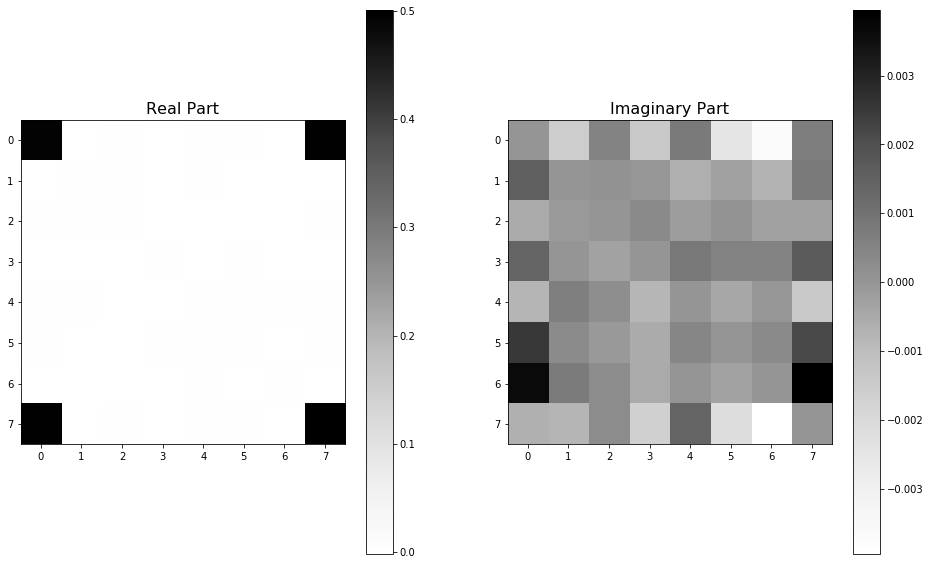

In [25]:
plot_density_matrix(density_matrix)

# References 

1 - [Altepeter et al - Quantum State Tomography](http://research.physics.illinois.edu/QI/Photonics/tomography-files/tomo_chapter_2004.pdf)

2 - [Qiskit Ignis Documentation](https://qiskit.org/documentation/apidoc/verification.html#tomography)

----------------------------------------------------------------------------------------------------

In [104]:
import qiskit.tools.jupyter
%qiskit_version_table